# Part 01 - EDA with Pyspark

Gradient Boosted Trees applied to Fraud detection

#### Pyspark libraries

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, countDistinct
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, array, lit
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.sql.functions import pow, col
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import col, countDistinct

#### Python libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
spark = SparkSession.builder.appName('FraudTreeMethods').getOrCreate()

## Read Data

In [47]:
# Load and parse the data file, converting it to a DataFrame.
#data = sqlContext.sql("SELECT * FROM fraud_train_sample_csv")
RDD = spark.read.csv('train_sample.csv', inferSchema=True, header=True)

In [48]:
RDD.show(5)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 87540| 12|     1| 13|    497|2017-11-07 09:30:38|           null|            0|
|105560| 25|     1| 17|    259|2017-11-07 13:40:27|           null|            0|
|101424| 12|     1| 19|    212|2017-11-07 18:05:24|           null|            0|
| 94584| 13|     1| 13|    477|2017-11-07 04:58:08|           null|            0|
| 68413| 12|     1|  1|    178|2017-11-09 09:00:09|           null|            0|
+------+---+------+---+-------+-------------------+---------------+-------------+
only showing top 5 rows



In [49]:
print('RDD.printSchema is \n')
RDD.printSchema()

RDD.printSchema is 

root
 |-- ip: integer (nullable = true)
 |-- app: integer (nullable = true)
 |-- device: integer (nullable = true)
 |-- os: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: integer (nullable = true)



## Convert the click time to day and hour and add it to data.

In [6]:
from pyspark.sql.functions import hour, minute, dayofmonth
RDD = RDD.withColumn('hour',hour(RDD.click_time)).\
             withColumn('day',dayofmonth(RDD.click_time))

RDD.show(5)

+------+---+------+---+-------+-------------------+---------------+-------------+----+---+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|hour|day|
+------+---+------+---+-------+-------------------+---------------+-------------+----+---+
| 87540| 12|     1| 13|    497|2017-11-07 09:30:38|           null|            0|   9|  7|
|105560| 25|     1| 17|    259|2017-11-07 13:40:27|           null|            0|  13|  7|
|101424| 12|     1| 19|    212|2017-11-07 18:05:24|           null|            0|  18|  7|
| 94584| 13|     1| 13|    477|2017-11-07 04:58:08|           null|            0|   4|  7|
| 68413| 12|     1|  1|    178|2017-11-09 09:00:09|           null|            0|   9|  9|
+------+---+------+---+-------+-------------------+---------------+-------------+----+---+
only showing top 5 rows



## Feathering

Feathering, grouping-merging as follow.

In python EDA we did following:
```python
gp = df[['ip','day','hour','channel']]\
    .groupby(by=['ip','day','hour'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': '*ip_day_hour_count_channel'})
df = df.merge(gp, on=['ip','day','hour'], how='left')

```
We translate it to Pyspark as follow.

In [7]:
gp = RDD.select("ip","day","hour", "channel")\
               .groupBy("ip","day","hour")\
               .agg({"channel":"count"})\
               .withColumnRenamed("count(channel)", "*ip_day_hour_count_channel")\
               .sort(col("ip"))
RDD = RDD.join(gp, ["ip","day","hour"])\
         .sort(col("ip"))

In [8]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'day', 'hour', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel']


In python EDA we did following:
```python
gp = df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].\
            count().reset_index().\
            rename(index=str, columns={'channel': '*ip_app_count_channel'})
df = df.merge(gp, on=['ip','app'], how='left')

```
We translate it to Pyspark as follow.

In [9]:
gp = RDD.select("ip","app", "channel")\
               .groupBy("ip","app")\
               .agg({"channel":"count"})\
               .withColumnRenamed("count(channel)", "*ip_app_count_channel")\
               .sort(col("ip"))
RDD = RDD.join(gp, ["ip","app"])\
         .sort(col("ip"))

In [10]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'app', 'day', 'hour', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel', '*ip_app_count_channel']


In python EDA we did following:
```python
gp = df[['ip','app', 'os', 'channel']].\
            groupby(by=['ip', 'app', 'os'])[['channel']].\
            count().reset_index().\
            rename(index=str, columns={'channel': '*ip_app_os_count_channel'})
df = df.merge(gp, on=['ip','app', 'os'], how='left')

```
We translate it to Pyspark as follow.

In [11]:
gp = RDD.select('ip','app', 'os', 'channel')\
               .groupBy('ip', 'app', 'os')\
               .agg({"channel":"count"})\
               .withColumnRenamed("count(channel)", "*ip_app_os_count_channel")\
               .sort(col("ip"))
RDD = RDD.join(gp, ['ip','app', 'os'])\
         .sort(col("ip"))

In [12]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'app', 'os', 'day', 'hour', 'device', 'channel', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel', '*ip_app_count_channel', '*ip_app_os_count_channel']


In python EDA we did following:
```python
gp = df[['ip','day','hour','channel']].\
            groupby(by=['ip','day','channel'])[['hour']].\
            var().reset_index().\
            rename(index=str, columns={'hour': '*ip_day_chan_var_hour'})
df = df.merge(gp, on=['ip','day','channel'], how='left')

```
We translate it to Pyspark as follow.

In [13]:
gp = RDD.select('ip','day','hour','channel')\
               .groupBy('ip','day','channel')\
               .agg({"hour":"variance"})\
               .withColumnRenamed("variance(hour)", "*ip_day_chan_var_hour")\
               .sort(col("ip"))

Check out the number of nan and null in the gp.

In [14]:
gp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in gp.columns]).show()

+---+---+-------+---------------------+
| ip|day|channel|*ip_day_chan_var_hour|
+---+---+-------+---------------------+
|  0|  0|      0|                89123|
+---+---+-------+---------------------+



We remeber from python EDA the following 

```python
ip                                0
app                               0
device                            0
os                                0
channel                           0
click_time                        0
is_attributed                     0
hour                              0
day                               0
*ip_day_hour_count_channel        0
*ip_app_count_channel             0
*ip_app_os_count_channel          0
*ip_tchan_count               89123
*ip_app_os_var                89715
*ip_app_channel_var_day       84834
*ip_app_channel_mean_hour         0
dtype: int64

```
Therefore we skip the following grouping (columns)as follow.

```python
*ip_tchan_count               10877 non-null float64
*ip_app_os_var                10285 non-null float64
*ip_app_channel_var_day       15166 non-null float64

```
Note that the last gp was not joined into the data.

**Let's Keep going:**

In python EDA we did following:
```python
gp = df[['ip','app', 'channel','hour']].\
            groupby(by=['ip', 'app', 'channel'])[['hour']].\
            mean().reset_index().\
            rename(index=str, columns={'hour': '*ip_app_channel_mean_hour'})

df = df.merge(gp, on=['ip','app', 'channel'], how='left')

```
We translate it to Pyspark as follow.

In [15]:
gp = RDD.select('ip','app', 'channel','hour')\
               .groupBy('ip', 'app', 'channel')\
               .agg({"hour":"mean"})\
               .withColumnRenamed("avg(hour)", "*ip_app_channel_mean_hour")\
               .sort(col("ip"))
RDD = RDD.join(gp, ['ip', 'app', 'channel'])\
         .sort(col("ip"))

In [16]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'app', 'channel', 'os', 'day', 'hour', 'device', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel', '*ip_app_count_channel', '*ip_app_os_count_channel', '*ip_app_channel_mean_hour']


In [17]:
RDD.show(5)

+---+---+-------+---+---+----+------+-------------------+---------------+-------------+--------------------------+---------------------+------------------------+-------------------------+
| ip|app|channel| os|day|hour|device|         click_time|attributed_time|is_attributed|*ip_day_hour_count_channel|*ip_app_count_channel|*ip_app_os_count_channel|*ip_app_channel_mean_hour|
+---+---+-------+---+---+----+------+-------------------+---------------+-------------+--------------------------+---------------------+------------------------+-------------------------+
|  9|  9|    244| 13|  7|  16|     1|2017-11-07 16:06:42|           null|            0|                         1|                    1|                       1|                     16.0|
| 10| 12|    140| 19|  7|   7|     1|2017-11-07 07:33:04|           null|            0|                         1|                    1|                       1|                      7.0|
| 10| 11|    319| 22|  7|   1|     1|2017-11-07 01:37:19|   

### Get summary

In [18]:
# data.summary().show()
cols1 = ['ip', 'app', 'channel',
       'os', 'day', 'hour']
RDD.describe(cols1).show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|summary|               ip|               app|           channel|               os|               day|             hour|
+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|  count|           100000|            100000|            100000|           100000|            100000|           100000|
|   mean|      91255.87967|          12.04788|         268.83246|         22.81828|           7.86146|          9.32859|
| stddev|69835.55366125253|14.941499924365017|129.72424821194429|55.94313589875118|0.8892663135111791|6.180585781971325|
|    min|                9|                 1|                 3|                0|                 6|                0|
|    max|           364757|               551|               498|              866|                 9|               23|
+-------+-----------------+-----

In [19]:
cols2 = ['device', 'click_time', 
        'attributed_time','is_attributed']
RDD.describe(cols2).show()

+-------+-----------------+-------------------+-------------------+-------------------+
|summary|           device|         click_time|    attributed_time|      is_attributed|
+-------+-----------------+-------------------+-------------------+-------------------+
|  count|           100000|             100000|                227|             100000|
|   mean|         21.77125|               null|               null|            0.00227|
| stddev|259.6677674200859|               null|               null|0.04759064770201691|
|    min|                0|2017-11-06 16:00:00|2017-11-06 17:19:04|                  0|
|    max|             3867|2017-11-09 15:59:51|2017-11-09 15:28:15|                  1|
+-------+-----------------+-------------------+-------------------+-------------------+



In [20]:
cols3 = ['*ip_day_hour_count_channel',
       '*ip_app_count_channel',
       '*ip_app_os_count_channel']
RDD.describe(cols3).show()

+-------+--------------------------+---------------------+------------------------+
|summary|*ip_day_hour_count_channel|*ip_app_count_channel|*ip_app_os_count_channel|
+-------+--------------------------+---------------------+------------------------+
|  count|                    100000|               100000|                  100000|
|   mean|                   1.49328|              3.58026|                 1.29488|
| stddev|        2.0205929005014096|   10.553763885539674|      1.6443882831400423|
|    min|                         1|                    1|                       1|
|    max|                        28|                  132|                      33|
+-------+--------------------------+---------------------+------------------------+



Check out the uniques number for each column in data.

In [21]:
cols4 = cols1 + cols2
RDD.agg(*(countDistinct(col(c)).alias(c) for c in cols4)).show()

+-----+---+-------+---+---+----+------+----------+---------------+-------------+
|   ip|app|channel| os|day|hour|device|click_time|attributed_time|is_attributed|
+-----+---+-------+---+---+----+------+----------+---------------+-------------+
|34857|161|    161|130|  4|  24|   100|     80350|            227|            2|
+-----+---+-------+---+---+----+------+----------+---------------+-------------+



In [22]:
RDD.agg(*(countDistinct(col(c)).alias(c) for c in cols3)).show()

+--------------------------+---------------------+------------------------+
|*ip_day_hour_count_channel|*ip_app_count_channel|*ip_app_os_count_channel|
+--------------------------+---------------------+------------------------+
|                        27|                   58|                      23|
+--------------------------+---------------------+------------------------+



## Over sampling the data

* Over sampling
* Duplicate the minority rows
* Combine both oversampled minority rows and previous majority rows

In [23]:
# over sampling
major_df = RDD.filter(col("is_attributed") == 0)
minor_df = RDD.filter(col("is_attributed") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))
a = range(ratio)

ratio: 439


In [24]:
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

In [25]:
# combine both oversampled minority rows and previous majority rows combined_df = major_df.unionAll(oversampled_df)
RDD = major_df.unionAll(oversampled_df)

In [26]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'app', 'channel', 'os', 'day', 'hour', 'device', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel', '*ip_app_count_channel', '*ip_app_os_count_channel', '*ip_app_channel_mean_hour']


### Turn RDD to pandas and use pandas ability for visualization

* First take a sample from big RDD
* Pass the sample into the pandas data frame

In [27]:
sub_RDD = RDD.sample(False, 0.01, 42)
data_pd = sub_RDD.toPandas()

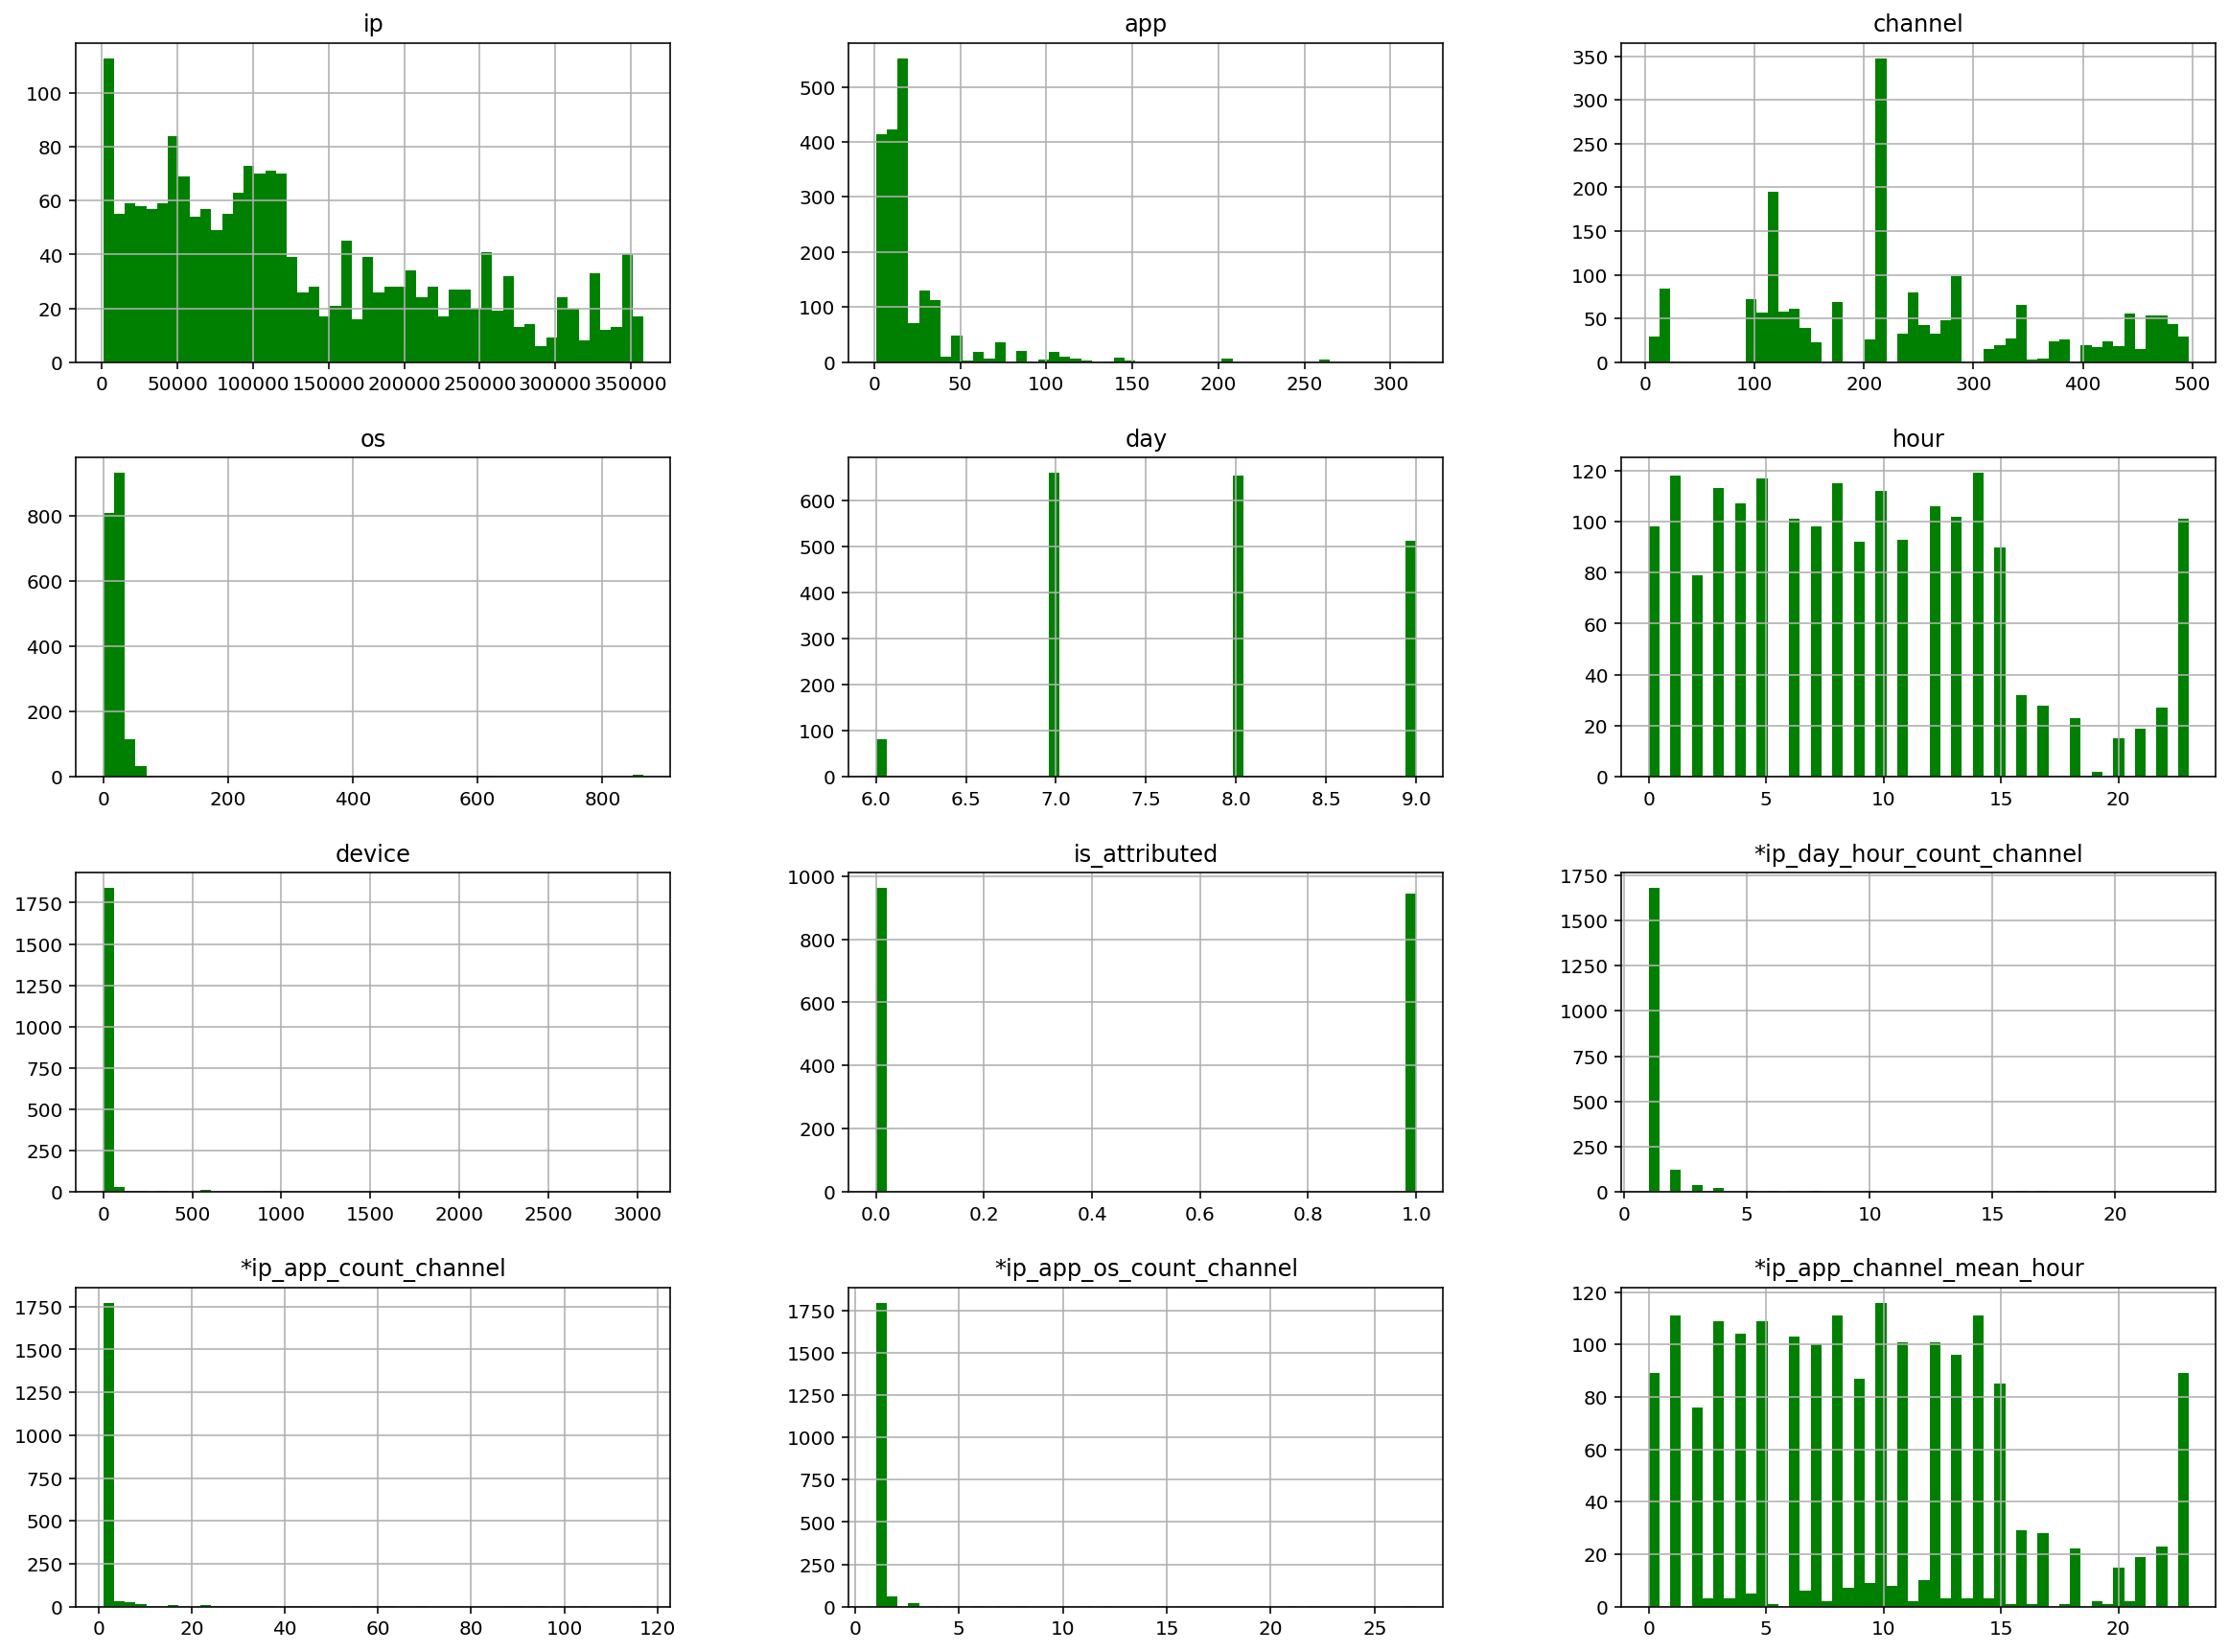

In [28]:
data_pd.hist(bins=50, 
             figsize=(20,15),
             facecolor='green')
plt.show()

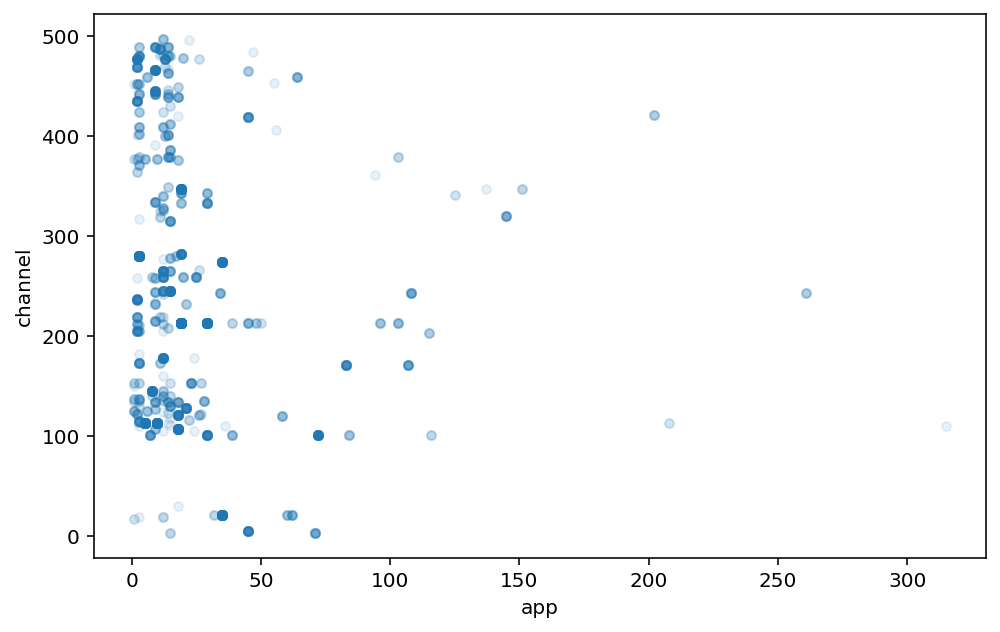

In [29]:
data_pd.plot(kind="scatter", 
             x="app", 
             y="channel", 
             alpha=0.1, 
             figsize=(8,5))

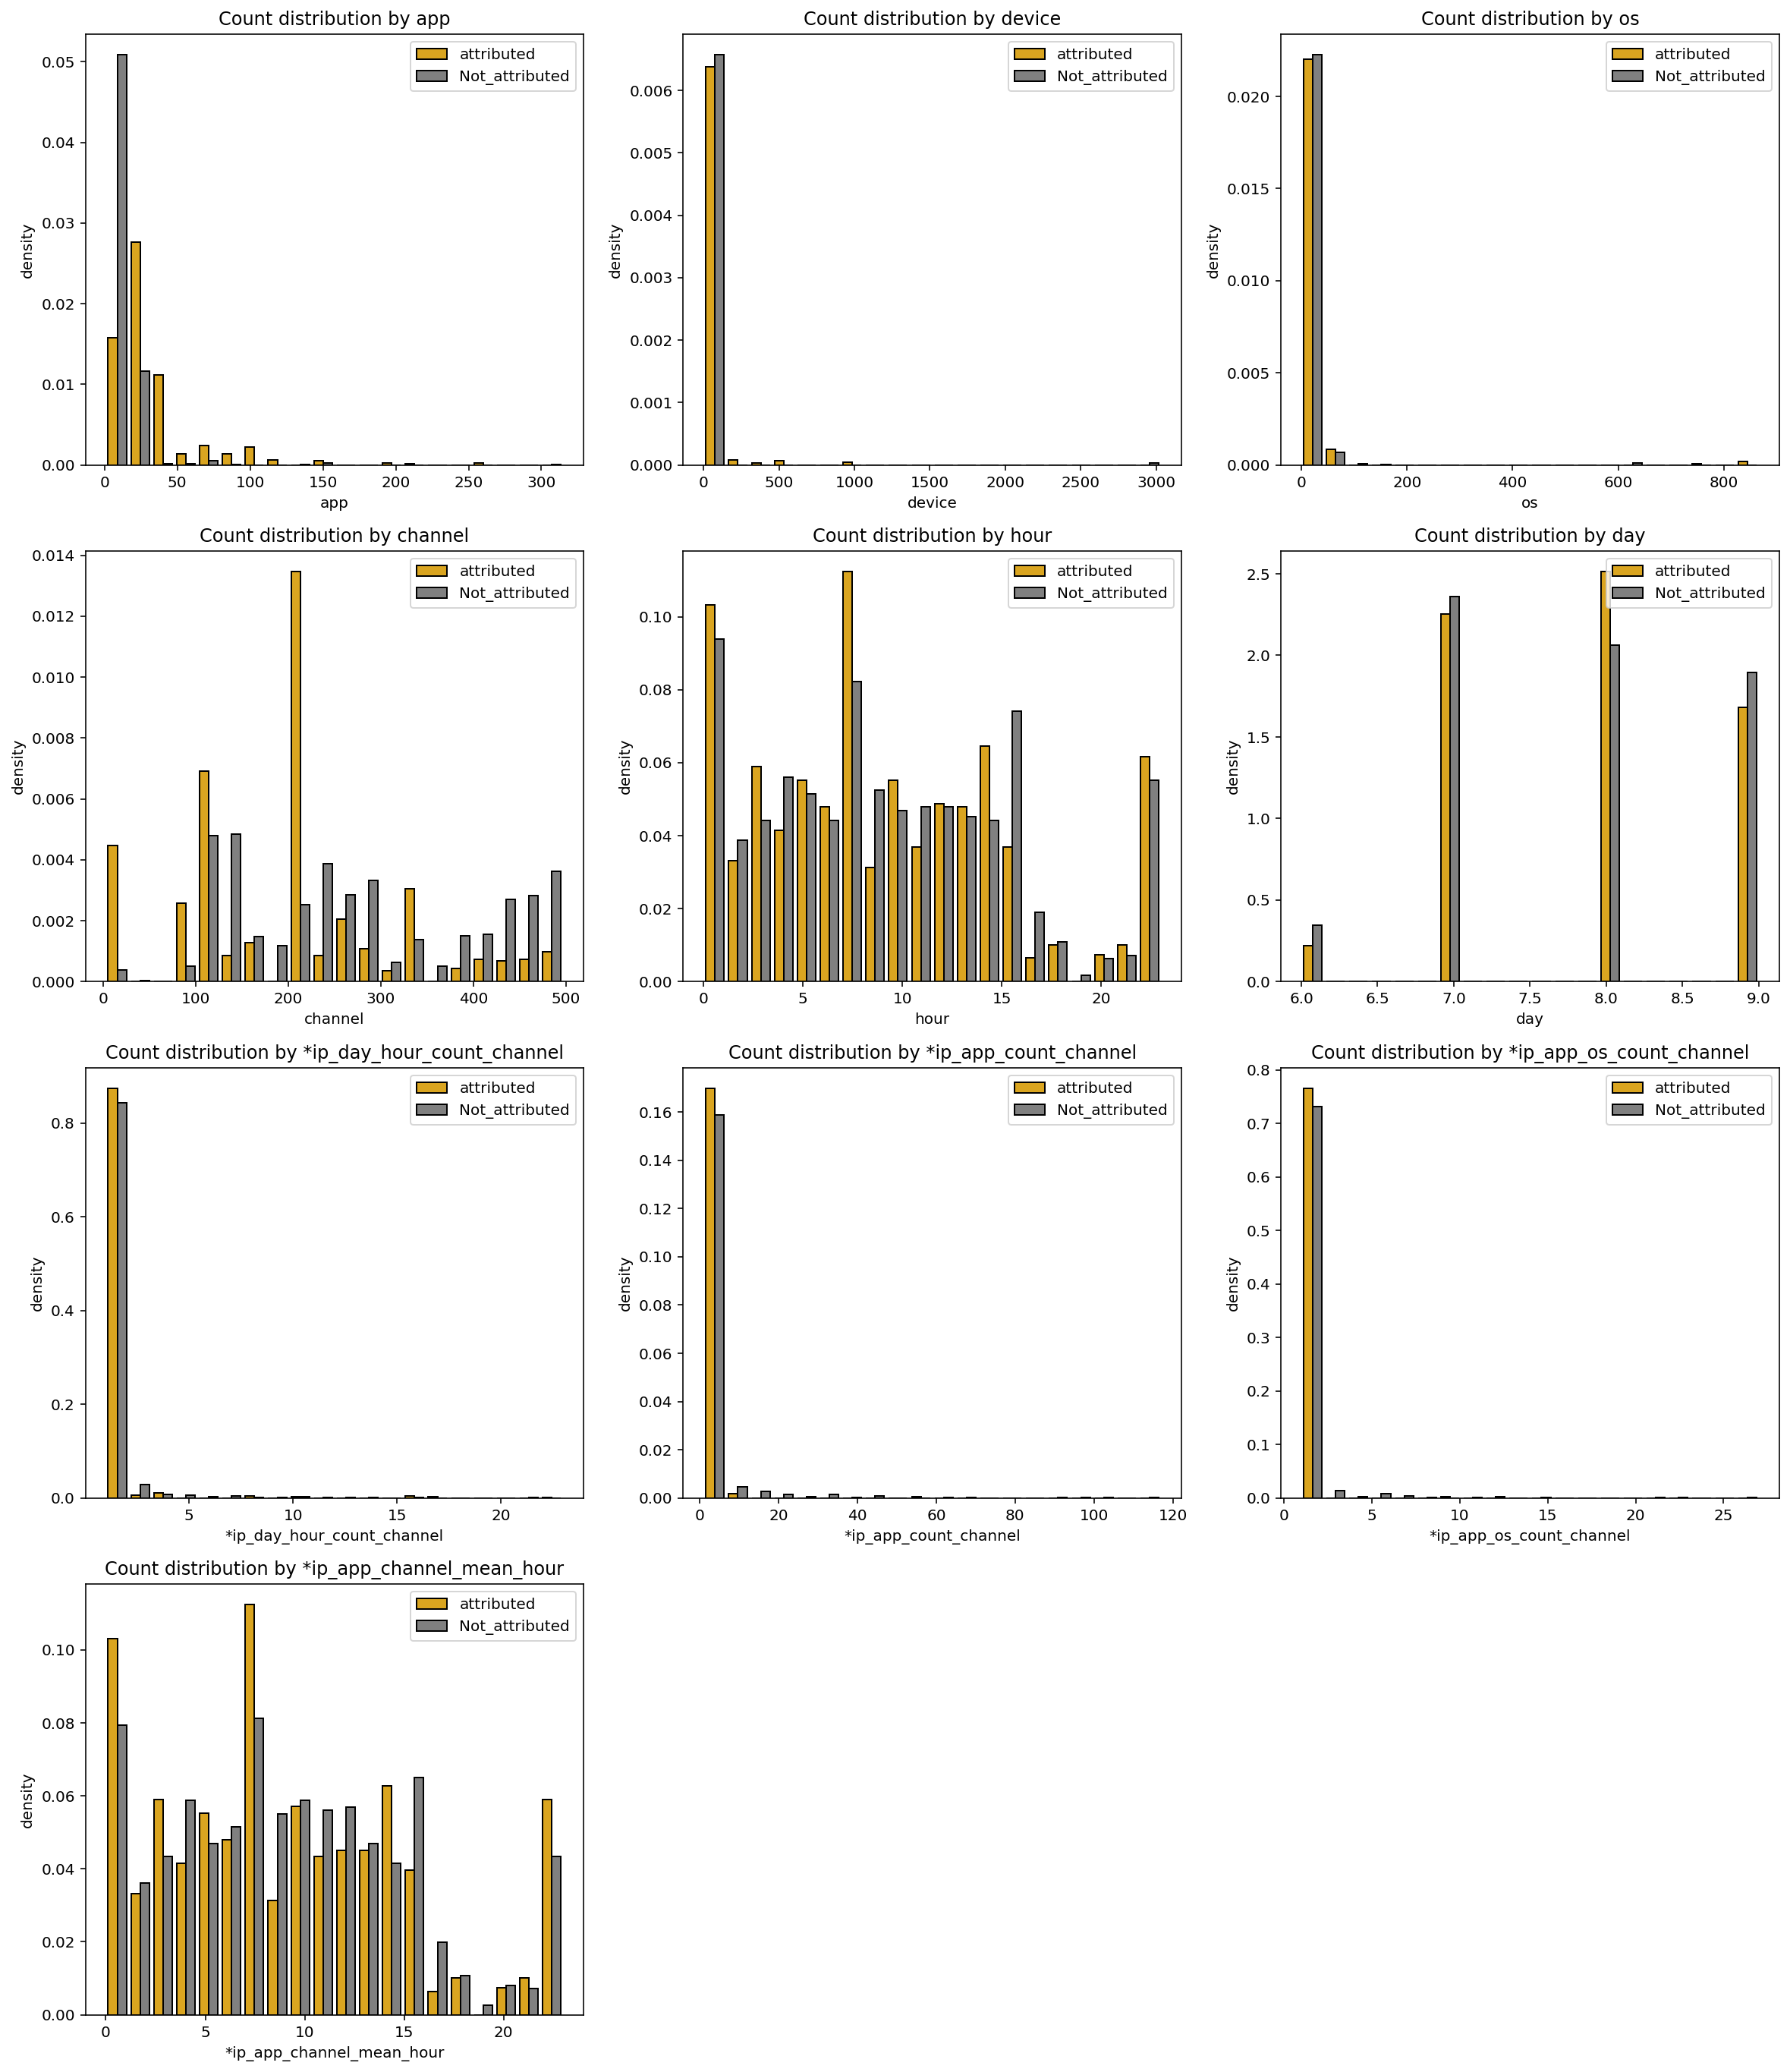

In [30]:
plt.figure(figsize=(20,24))

cols = ['app','device','os', 
        'channel', 'hour', 'day',
        '*ip_day_hour_count_channel', '*ip_app_count_channel',
        '*ip_app_os_count_channel', '*ip_app_channel_mean_hour']

sub_attributed_mask = data_pd["is_attributed"] == 1
sub_Not_attributed_mask = data_pd["is_attributed"] == 0


for count, col in enumerate(cols, 1):
    
    plt.subplot(4, 3, count)
    plt.hist([data_pd[sub_attributed_mask][col], 
          data_pd[sub_Not_attributed_mask][col]],
          color=['goldenrod', 'grey'],
          bins=20, ec='k', density=True)
    
    plt.title('Count distribution by {}'.format(col), fontsize=12)
    plt.legend(['attributed', 'Not_attributed'])
    plt.xlabel(col); plt.ylabel('density')

# path = '../Figures/'
# file_name = 'hist_dens_by_par.png'
# plt.savefig(path+file_name)

### Transfering

Applying the transfering achieved from previous EDA.

In [31]:
trans_colmns = ['app','device','os', 'day', 
                '*ip_day_hour_count_channel', 
                '*ip_app_count_channel', 
                '*ip_app_os_count_channel']

In [32]:
def transformer(x):
    x = pow(x, (0.05))
    return x

Apply the defined function into each column as follow

In [33]:
RDD = RDD.withColumn("app", transformer('app'))
RDD = RDD.withColumn("device", transformer('device'))
RDD = RDD.withColumn("os", transformer('os'))
RDD = RDD.withColumn("day", transformer('day'))

RDD = RDD.withColumn("*ip_day_hour_count_channel", transformer('*ip_day_hour_count_channel'))

RDD = RDD.withColumn("*ip_app_count_channel", transformer('*ip_app_count_channel'))

RDD = RDD.withColumn("*ip_app_os_count_channel", transformer('*ip_app_os_count_channel'))
RDD.show()

+---+------------------+-------+------------------+------------------+----+------------------+-------------------+---------------+-------------+--------------------------+---------------------+------------------------+-------------------------+
| ip|               app|channel|                os|               day|hour|            device|         click_time|attributed_time|is_attributed|*ip_day_hour_count_channel|*ip_app_count_channel|*ip_app_os_count_channel|*ip_app_channel_mean_hour|
+---+------------------+-------+------------------+------------------+----+------------------+-------------------+---------------+-------------+--------------------------+---------------------+------------------------+-------------------------+
|  9|1.1161231740339044|    244|1.1368342978555985|1.1021860296878503|  16|               1.0|2017-11-07 16:06:42|           null|            0|                       1.0|                  1.0|                     1.0|                     16.0|
| 10| 1.127378204157

In [34]:
RDD.columns

['ip',
 'app',
 'channel',
 'os',
 'day',
 'hour',
 'device',
 'click_time',
 'attributed_time',
 'is_attributed',
 '*ip_day_hour_count_channel',
 '*ip_app_count_channel',
 '*ip_app_os_count_channel',
 '*ip_app_channel_mean_hour']

Drop the click time and attributed time

In [35]:
RDD = RDD.drop('click_time','attributed_time')

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = RDD.randomSplit([0.7, 0.3])

cols = ['ip',
 'app',
 'channel',
 'os',
 'day',
 'hour',
 'device',
 'is_attributed',
 '*ip_day_hour_count_channel',
 '*ip_app_count_channel',
 '*ip_app_os_count_channel',
 '*ip_app_channel_mean_hour']

assembler = VectorAssembler(inputCols = cols,outputCol="features")
trainingData = assembler.transform(trainingData)
testData = assembler.transform(testData)

## Train the model

In [36]:
# Train a GBT model.
gbt = GBTClassifier(labelCol="is_attributed", featuresCol="features", maxIter=20, maxDepth=4)

# Train model.  This also runs the indexers.
model = gbt.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "is_attributed", "features").show(5)

+----------+-------------+--------------------+
|prediction|is_attributed|            features|
+----------+-------------+--------------------+
|       0.0|            0|[10.0,1.155483172...|
|       0.0|            0|[27.0,1.0,439.0,1...|
|       0.0|            0|[27.0,1.035264923...|
|       0.0|            0|[59.0,1.056467308...|
|       0.0|            0|[59.0,1.132293625...|
+----------+-------------+--------------------+
only showing top 5 rows



In [37]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="is_attributed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Test accuracy = %g" % (accuracy))

Test Error = 0
Test accuracy = 1


In [38]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|30046|
|       1.0|29967|
+----------+-----+



# Apply to test, predict

In [39]:
test = spark.read.csv('test.csv', inferSchema=True, header=True)
test.show(5)

+--------+------+---+------+---+-------+-------------------+
|click_id|    ip|app|device| os|channel|         click_time|
+--------+------+---+------+---+-------+-------------------+
|       0|  5744|  9|     1|  3|    107|2017-11-10 04:00:00|
|       1|119901|  9|     1|  3|    466|2017-11-10 04:00:00|
|       2| 72287| 21|     1| 19|    128|2017-11-10 04:00:00|
|       3| 78477| 15|     1| 13|    111|2017-11-10 04:00:00|
|       4|123080| 12|     1| 13|    328|2017-11-10 04:00:00|
+--------+------+---+------+---+-------+-------------------+
only showing top 5 rows



Compare the train data schema with the test make sure about dimensions.


```python
RDD.printSchema is 

root
 |-- ip: integer (nullable = true)
 |-- app: integer (nullable = true)
 |-- device: integer (nullable = true)
 |-- os: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: integer (nullable = true)

```

In [50]:
print('test.printSchema is \n')
test.printSchema()

test.printSchema is 

root
 |-- click_id: integer (nullable = true)
 |-- ip: integer (nullable = true)
 |-- app: integer (nullable = true)
 |-- device: integer (nullable = true)
 |-- os: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- click_time: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)



In [40]:
from pyspark.sql.functions import hour, minute, dayofmonth
test = test.withColumn('hour',hour(test.click_time)).\
             withColumn('day',dayofmonth(test.click_time))

test.show(5)

+--------+------+---+------+---+-------+-------------------+----+---+
|click_id|    ip|app|device| os|channel|         click_time|hour|day|
+--------+------+---+------+---+-------+-------------------+----+---+
|       0|  5744|  9|     1|  3|    107|2017-11-10 04:00:00|   4| 10|
|       1|119901|  9|     1|  3|    466|2017-11-10 04:00:00|   4| 10|
|       2| 72287| 21|     1| 19|    128|2017-11-10 04:00:00|   4| 10|
|       3| 78477| 15|     1| 13|    111|2017-11-10 04:00:00|   4| 10|
|       4|123080| 12|     1| 13|    328|2017-11-10 04:00:00|   4| 10|
+--------+------+---+------+---+-------+-------------------+----+---+
only showing top 5 rows



Apply feathering to test

In [54]:
gp = test.select("ip","day","hour", "channel")\
               .groupBy("ip","day","hour")\
               .agg({"channel":"count"})\
               .withColumnRenamed("count(channel)", "*ip_day_hour_count_channel")

test = test.join(gp, ["ip","day","hour"])

In [55]:
gp = test.select("ip","app", "channel")\
               .groupBy("ip","app")\
               .agg({"channel":"count"})\
               .withColumnRenamed("count(channel)", "*ip_app_count_channel")

test = test.join(gp, ["ip","app"])

In [56]:
gp = test.select('ip','app', 'os', 'channel')\
               .groupBy('ip', 'app', 'os')\
               .agg({"channel":"count"})\
               .withColumnRenamed("count(channel)", "*ip_app_os_count_channel")

test = test.join(gp, ['ip','app', 'os'])

In [57]:
gp = test.select('ip','app', 'channel','hour')\
               .groupBy('ip', 'app', 'channel')\
               .agg({"hour":"mean"})\
               .withColumnRenamed("avg(hour)", "*ip_app_channel_mean_hour")

test = test.join(gp, ['ip', 'app', 'channel'])

In [58]:
test.show(5)

+---+---+-------+---+---+----+--------+------+-------------------+--------------------------+---------------------+------------------------+-------------------------+
| ip|app|channel| os|day|hour|click_id|device|         click_time|*ip_day_hour_count_channel|*ip_app_count_channel|*ip_app_os_count_channel|*ip_app_channel_mean_hour|
+---+---+-------+---+---+----+--------+------+-------------------+--------------------------+---------------------+------------------------+-------------------------+
|  6| 25|    259| 19| 10|   5| 3991773|     1|2017-11-10 05:12:48|                        34|                    2|                       2|                      5.0|
|  6| 25|    259| 19| 10|   5| 3991858|     1|2017-11-10 05:12:48|                        34|                    2|                       2|                      5.0|
| 10|  2|    237| 25| 10|  10|11548328|     1|2017-11-10 10:45:12|                        23|                   19|                       1|                     10.0

In [60]:
test = test.withColumn("app", transformer('app'))
test = test.withColumn("device", transformer('device'))
test = test.withColumn("os", transformer('os'))
test = test.withColumn("day", transformer('day'))

test = test.withColumn("*ip_day_hour_count_channel", transformer('*ip_day_hour_count_channel'))

test = test.withColumn("*ip_app_count_channel", transformer('*ip_app_count_channel'))

test = test.withColumn("*ip_app_os_count_channel", transformer('*ip_app_os_count_channel'))

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


Py4JError: functions does not exist in the JVM

In [ ]:
test.show(5)

In [ ]:
assembler = VectorAssembler(inputCols = cols,outputCol="features")
test = assembler.transform(test)
#test.show(3)

predictions = model.transform(test)
#predictions.show(2)

data_to_submit = predictions.select(['click_id','prediction'])
data_to_submit.show(3)

data_to_submit = data_to_submit.withColumnRenamed('prediction','is_attributed')
data_to_submit.show(3)

data_to_submit.groupBy('is_attributed').count().show()